<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-3-public/blob/main/Course%202%20-%20Custom%20Training%20loops%2C%20Gradients%20and%20Distributed%20Training/Week%202%20-%20Simple%20Custom%20Training/C2_W2_Lab_2_training-categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST using Custom Training Loop
In this ungraded lab, you will build a custom training loop including a validation loop so as to train a model on the [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

## Load and Preprocess Data
You will load the [Fashion MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset using Tensorflow Datasets. This dataset has 28 x 28 grayscale images of articles of clothing belonging to 10 clases.

Here you are going to use the training and testing splits of the data. Testing split will be used for validation.

In [4]:
train_data, info = tfds.load("fashion_mnist", split = "train", with_info = True, data_dir='./data/', download=False)
test_data = tfds.load("fashion_mnist", split = "test", data_dir='./data/', download=False)

In [5]:
class_names = ["T-shirt/top", "Trouser/pants", "Pullover shirt", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Next, you normalize the images by dividing them by 255.0 so as to make the pixels fall in the range (0, 1). You also reshape the data so as to flatten the 28 x 28 pixel array into a flattened 784 pixel array.

In [6]:
!ls -l ./data/

total 4
drwxrwxrwx 3 nobody nogroup 6144 Jun 14 19:54 fashion_mnist


In [7]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [8]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

Now you shuffle and batch your training and test datasets before feeding them to the model.

In [9]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

## Define the Model
You are using a simple model in this example. You use Keras Functional API to connect two dense layers. The final layer is a softmax that outputs one of the 10 classes since this is a multi class classification problem.

In [10]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

## Define Optimizer and Loss Function

You have chosen `adam` optimizer and sparse categorical crossentropy loss for this example.

In [11]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

## Define Metrics

You will also define metrics so that your training loop can update and display them. Here you are using `SparseCategoricalAccuracy`defined in `tf.keras.metrics` since the problem at hand is a multi class classification problem.

In [12]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building Training Loop
In this section you build your training loop consisting of training and validation sequences.

The core of training is using the model to calculate the logits on specific set of inputs and compute loss (in this case **sparse categorical crossentropy**) by comparing the predicted outputs to the true outputs. You then update the trainable weights using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

You use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

In [13]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  
  return logits, loss_value

This function performs training during one epoch. You run through all batches of training data in each epoch to make updates to trainable weights using your previous function. You can see that we also call update_state on your metrics to accumulate the value of your metrics.
You are displaying a progress bar to indicate completion of training in each epoch. Here you use tqdm for displaying the progress bar.

In [14]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      
      losses.append(loss_value)
      
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

At the end of each epoch you have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [15]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

Next you define the training loop that runs through the training samples repeatedly over a fixed number of epochs. Here you combine the functions you built earlier to establish the following flow:
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

**Note** : You also calculate the training and validation losses for the whole epoch at the end of the epoch.

In [16]:

model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()




Start of epoch 0


Training loss for step 937: 0.2753: 100%|██████████| 938/938 


 Epoch 0: Train loss: 0.5443  Validation Loss: 0.4559, Train Accuracy: 0.8097, Validation Accuracy 0.8394
Start of epoch 1


Training loss for step 937: 0.2773: 100%|██████████| 938/938 


 Epoch 1: Train loss: 0.3948  Validation Loss: 0.4143, Train Accuracy: 0.8589, Validation Accuracy 0.8546
Start of epoch 2


Training loss for step 937: 0.4698: 100%|█████████▉| 937/938 


 Epoch 2: Train loss: 0.3545  Validation Loss: 0.3896, Train Accuracy: 0.8730, Validation Accuracy 0.8636
Start of epoch 3


Training loss for step 937: 0.2391: 100%|█████████▉| 937/938 


 Epoch 3: Train loss: 0.3322  Validation Loss: 0.3931, Train Accuracy: 0.8786, Validation Accuracy 0.8644
Start of epoch 4


Training loss for step 937: 0.2417: 100%|█████████▉| 937/938 


 Epoch 4: Train loss: 0.3125  Validation Loss: 0.3519, Train Accuracy: 0.8862, Validation Accuracy 0.8775
Start of epoch 5


Training loss for step 937: 0.2792: 100%|█████████▉| 937/938 


 Epoch 5: Train loss: 0.2981  Validation Loss: 0.3550, Train Accuracy: 0.8903, Validation Accuracy 0.8763
Start of epoch 6


Training loss for step 937: 0.1907: 100%|█████████▉| 937/938 


 Epoch 6: Train loss: 0.2841  Validation Loss: 0.3689, Train Accuracy: 0.8950, Validation Accuracy 0.8716
Start of epoch 7


Training loss for step 937: 0.2575: 100%|█████████▉| 937/938 


 Epoch 7: Train loss: 0.2745  Validation Loss: 0.3591, Train Accuracy: 0.8993, Validation Accuracy 0.8737
Start of epoch 8


Training loss for step 937: 0.0872: 100%|█████████▉| 937/938 


 Epoch 8: Train loss: 0.2641  Validation Loss: 0.3580, Train Accuracy: 0.9018, Validation Accuracy 0.8755
Start of epoch 9


Training loss for step 937: 0.0902: 100%|█████████▉| 937/938 


 Epoch 9: Train loss: 0.2567  Validation Loss: 0.3494, Train Accuracy: 0.9056, Validation Accuracy 0.8817


Training loss for step 937: 0.0902: 100%|██████████| 938/938 

## Evaluate Model

### Plots for Evaluation
You plot the progress of loss as training proceeds over number of epochs.

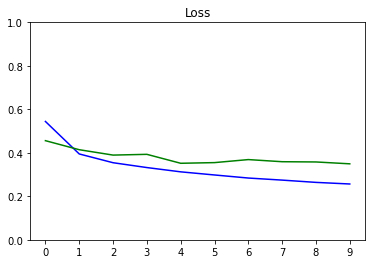

In [17]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

This function displays a row of images with their predictions and true labels.

In [20]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

You make predictions on the test dataset and plot the images with their true and predicted values.

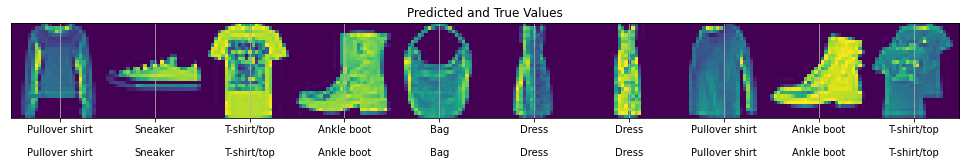

In [19]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)